# Proyecto Malaria CNN Simple

## Bibliotecas

In [1]:
import kagglehub
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import shutil
import numpy as np
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import shutil

## Descargando los datos

In [2]:
# Fuente: https://www.kaggle.com/datasets/rajsahu2004/lacuna-malaria-detection-dataset

# Download latest version
path = kagglehub.dataset_download("rajsahu2004/lacuna-malaria-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.99G/3.99G [00:57<00:00, 75.1MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/rajsahu2004/lacuna-malaria-detection-dataset/versions/1


In [3]:
!ls  /root/.cache/kagglehub/datasets/rajsahu2004/lacuna-malaria-detection-dataset/versions/1 -lsh

total 1.5M
144K drwxr-xr-x 2 root root 140K Nov 25 18:35 images
156K -rw-r--r-- 1 root root 155K Nov 25 18:35 SampleSubmission.csv
 28K -rw-r--r-- 1 root root  28K Nov 25 18:35 Test.csv
1.1M -rw-r--r-- 1 root root 1.1M Nov 25 18:35 Train.csv


# Analisis Exploratorio de Datos

El conjunto de datos, descargado de Kaggle, pertenece al dominio de detección de malaria mediante imágenes de células sanguíneas. Este conjunto de datos esta compuesto por los siguientes archivos y carpetas:

- **images**.
Este directorio contiene las imágenes utilizadas para la tarea de clasificación. Incluye imágenes de células sanguíneas infectadas y no infectadas por malaria.

- **SampleSubmission.csv**.
Este archivo es un ejemplo del formato esperado para las predicciones de clasificación.

- **Test.csv**.
Contiene información sobre las imágenes de prueba.

- **Train.csv**.
Este archivo contiene los datos de entrenamiento, que son una lista de imágenes junto con sus etiquetas correspondientes.

## images

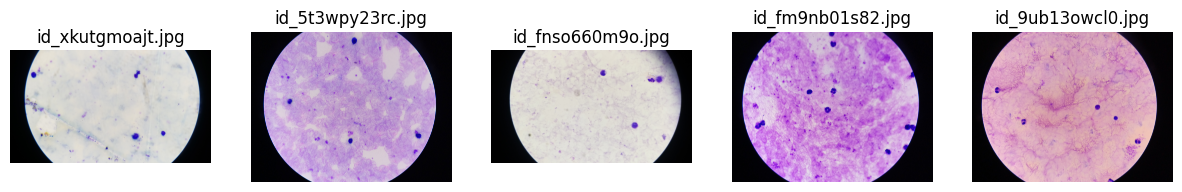

In [4]:
# prompt: Visualiza una muestra de las imagenes que se encuentren en !ls  /root/.cache/kagglehub/datasets/rajsahu2004/lacuna-malaria-detection-dataset/versions/1

# Path to the image directory
image_dir = path+'/images'

# Number of images to display
num_images_to_display = 5

# Get a list of image files in the directory
image_files = [f for f in np.random.choice(os.listdir(image_dir),num_images_to_display) if os.path.isfile(os.path.join(image_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Check if any images are found
if not image_files:
    print("No images found in the specified directory.")
else:
    # Display a sample of images
    fig, axes = plt.subplots(1, min(num_images_to_display, len(image_files)), figsize=(15, 5))
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)
        try:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
            axes[i].imshow(img)
            axes[i].set_title(image_file)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error displaying image {image_file}: {e}")
    plt.show()

## SampleSubmission.csv

In [5]:
df_sample_sub = pd.read_csv(path+'/SampleSubmission.csv')
df_sample_sub.head()

Image_ID        class  confidence  ymin  xmin  ymax  xmax
0  id_02i83lum2m.jpg          NEG         0.5   100   100   100   100
1  id_02i83lum2m.jpg  Trophozoite         0.5   100   100   100   100
2  id_02i83lum2m.jpg          WBC         0.5   100   100   100   100
3  id_02kpdbnrfn.jpg          NEG         0.5   100   100   100   100
4  id_02kpdbnrfn.jpg  Trophozoite         0.5   100   100   100   100

In [6]:
df_sample_sub.shape

(3534, 7)

In [7]:
df_sample_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Image_ID    3534 non-null   object 
 1   class       3534 non-null   object 
 2   confidence  3534 non-null   float64
 3   ymin        3534 non-null   int64  
 4   xmin        3534 non-null   int64  
 5   ymax        3534 non-null   int64  
 6   xmax        3534 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 193.4+ KB


## Test.csv

In [8]:
#Test.csv
df_test = pd.read_csv(path+'/Test.csv')
df_test.head()

Image_ID  class  confidence  ymin  xmin  ymax  xmax
0  id_5n9ov0rr22.jpg    NaN         NaN   NaN   NaN   NaN   NaN
1  id_k6s11k3klo.jpg    NaN         NaN   NaN   NaN   NaN   NaN
2  id_eftvcf9djb.jpg    NaN         NaN   NaN   NaN   NaN   NaN
3  id_kc5tmoj1xa.jpg    NaN         NaN   NaN   NaN   NaN   NaN
4  id_tirid4qt68.jpg    NaN         NaN   NaN   NaN   NaN   NaN

In [9]:
df_test.shape

(1178, 7)

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178 entries, 0 to 1177
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Image_ID    1178 non-null   object 
 1   class       0 non-null      float64
 2   confidence  0 non-null      float64
 3   ymin        0 non-null      float64
 4   xmin        0 non-null      float64
 5   ymax        0 non-null      float64
 6   xmax        0 non-null      float64
dtypes: float64(6), object(1)
memory usage: 64.5+ KB


## Train.csv

- **Columnas:**
    - `Image_ID`: Identificador único de las imágenes.
    - `class`: Clase de la imagen (e.g., Trophozoite, NEG para negativos).
    - `confidence`: Confianza asociada (en este caso, siempre 1.0).
    - `ymin`, `xmin`, `ymax`, `xmax`: Coordenadas de un cuadro delimitador (bounding box) para objetos relevantes en la imagen.


In [11]:
df_train = pd.read_csv(path+'/Train.csv')
df_train.head()

Image_ID        class  confidence  ymin  xmin  ymax  xmax
0  id_u3q6jdck4j.jpg  Trophozoite         1.0   712  1241   737  1270
1  id_a6cl90trri.jpg  Trophozoite         1.0   558  1566   600  1604
2  id_qvc2le9sm8.jpg  Trophozoite         1.0  1317  2788  1448  2914
3  id_w8xnbd5rvm.jpg  Trophozoite         1.0   925  1744  1041  1823
4  id_6dop09rk02.jpg          NEG         1.0     0     0     0     0

In [12]:
df_train.shape

(23530, 7)

###Distribución de Clases en Train.csv

In [13]:
# Calcular la distribución de la variable 'class'
class_distribution = df_train['class'].value_counts().reset_index()
class_distribution.columns = ['class', 'count']
class_distribution

class  count
0  Trophozoite  15838
1          WBC   7004
2          NEG    688

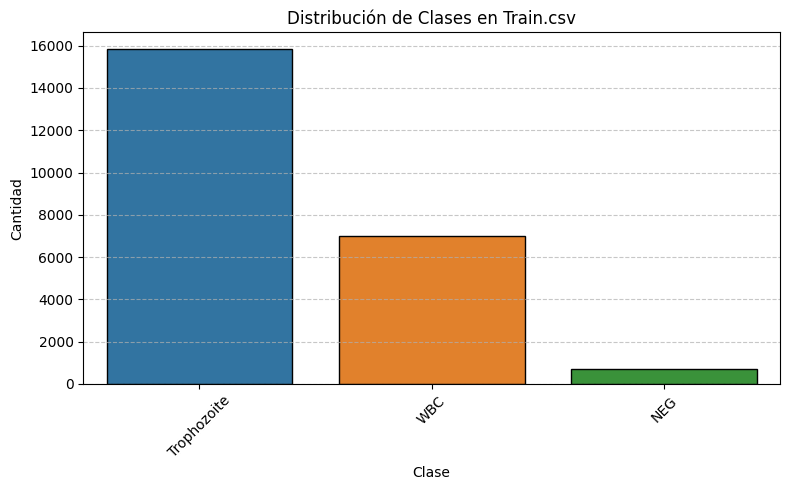

In [14]:
# Graficar la distribución de clases con Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(
    data=class_distribution,
    x='class',
    y='count',
    hue='class',
    dodge=False,  # Asegurarse de que no haya separación por hue
    edgecolor='black',
    legend=False
)
plt.title('Distribución de Clases en Train.csv')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Entendiendo datos en las imagenes

Los **bounding box coordinates** son valores que definen un rectángulo alrededor de un objeto de interés dentro de una imagen. Este rectángulo se utiliza comúnmente en tareas de visión por computadora, como la detección de objetos, para localizar y delimitar objetos específicos dentro de una imagen.

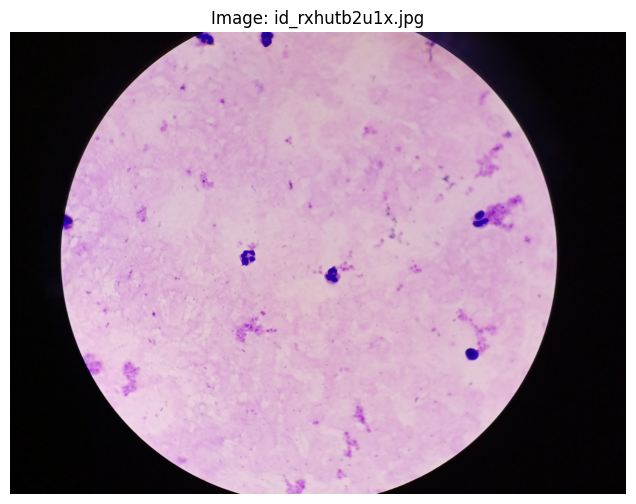

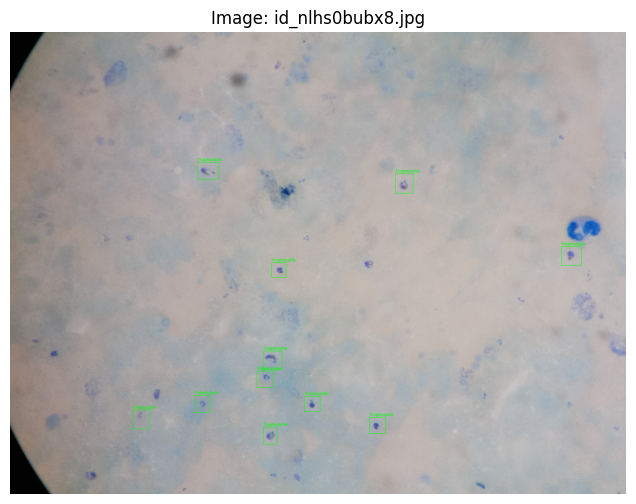

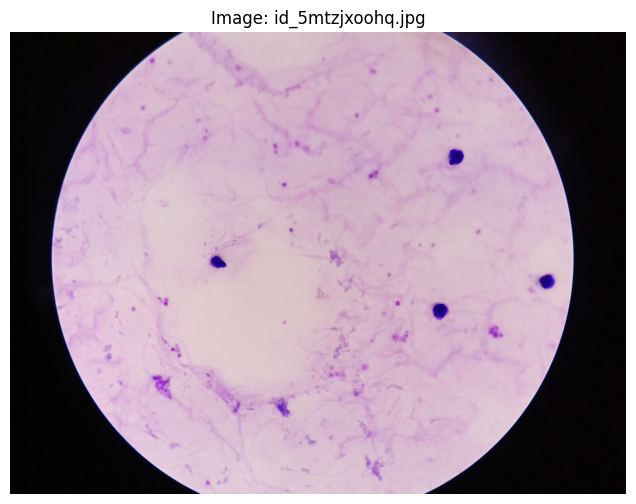

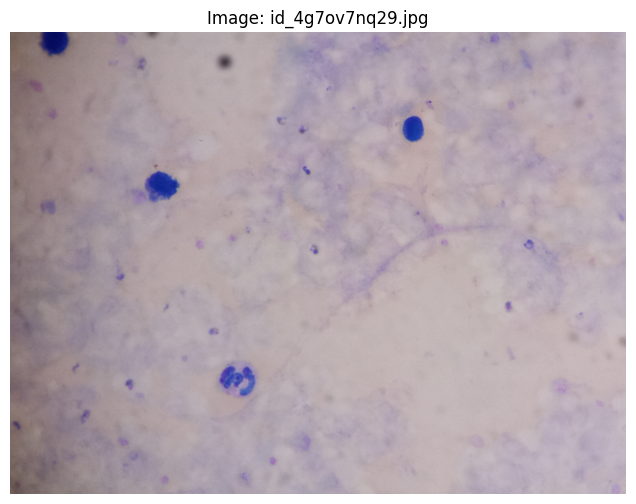

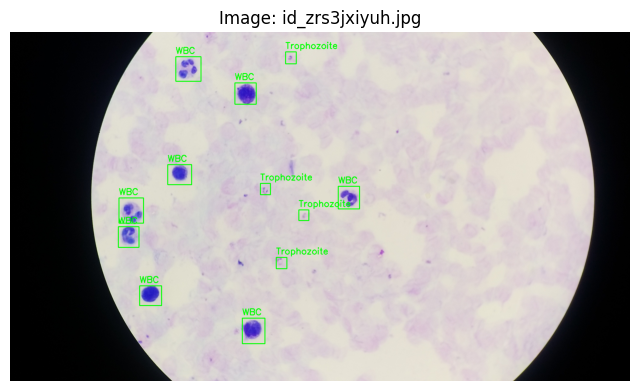

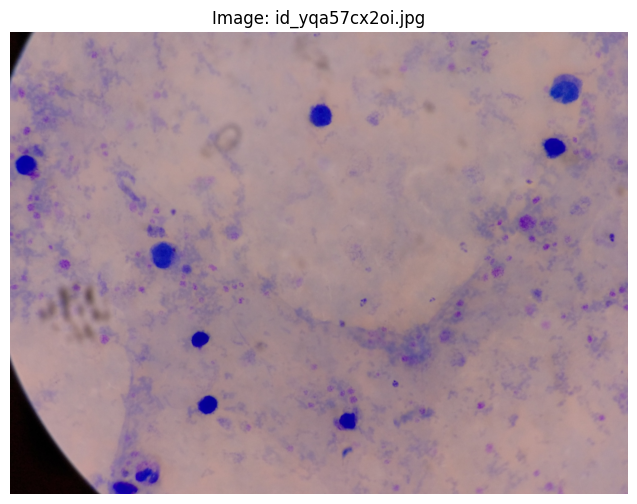

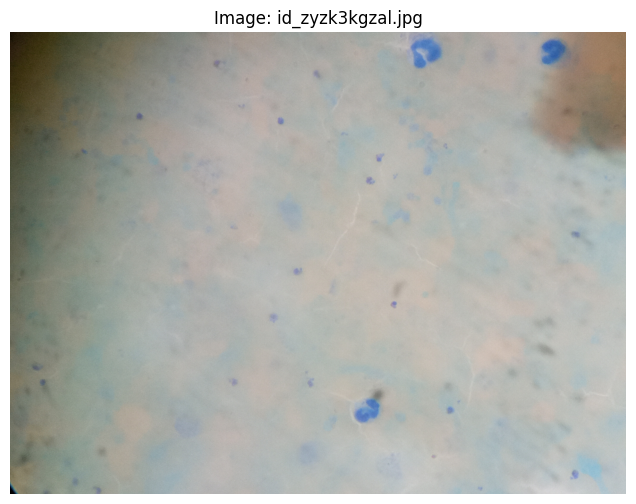

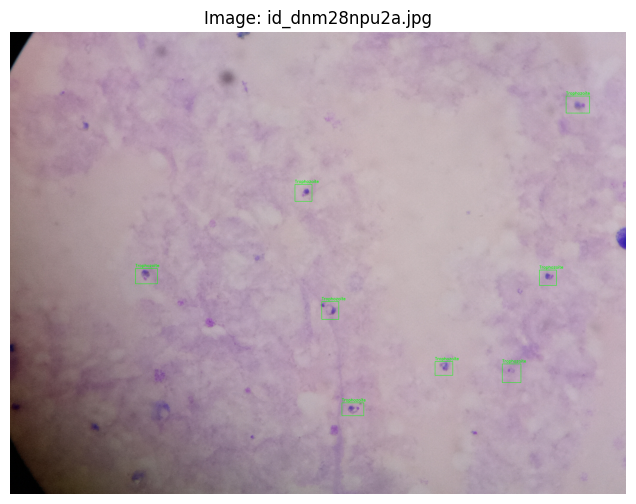

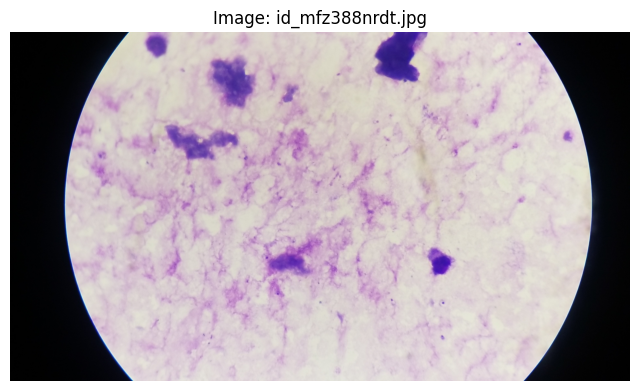

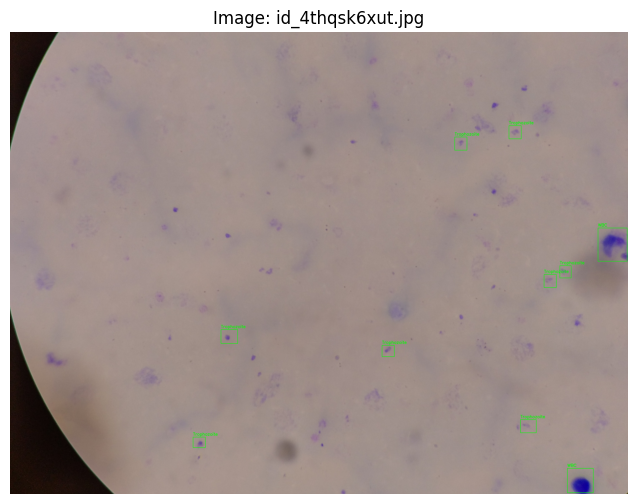

In [15]:
# prompt: de la celda entarior por cada cajita coloca la classee


# Assuming df_train contains 'Image_ID', 'xmin', 'ymin', 'xmax', 'ymax' columns
# and the image directory is '/root/.cache/kagglehub/datasets/rajsahu2004/lacuna-malaria-detection-dataset/versions/1/train'

# Path to the image directory
image_dir = path+'/images'

# Number of images to display
num_images_to_display = 10

for image_file in np.random.choice(os.listdir(image_dir),num_images_to_display):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_dir, image_file)
        image_id = image_file  # Assuming the filename is the Image_ID

        try:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Filter the dataframe to get bounding box info for this image
            image_data = df_train[df_train['Image_ID'] == image_id]

            for index, row in image_data.iterrows():
                xmin = int(row['xmin'])
                ymin = int(row['ymin'])
                xmax = int(row['xmax'])
                ymax = int(row['ymax'])
                class_name = row['class'] # Get the class label

                # Draw bounding box on the image
                cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

                # Add class label text
                cv2.putText(img, class_name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)


            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.title(f"Image: {image_id}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error processing image {image_file}: {e}")

In [16]:
# prompt: crea una data frame con ancho alruta y numero de canales de las imagenes que vienen en la carpeta

# Path to the image directory
image_dir = path+'/images'

image_data = []
for filename in os.listdir(image_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        filepath = os.path.join(image_dir, filename)
        try:
            img = cv2.imread(filepath)
            if img is not None:  # Check if the image was loaded successfully
                height, width, num_canales = img.shape
                image_data.append([filename, width, height, num_canales])
            else:
                print(f"Error: Could not read image file {filepath}")
        except Exception as e:
            print(f"Error processing image {filename}: {e}")

df = pd.DataFrame(image_data, columns=['filename', 'width', 'height', 'num_calanes'])
print(df.head())

            filename  width  height  num_calanes
0  id_kilinfd1fa.jpg   4032    3016            3
1  id_66g6mwyqq1.jpg   1920    1080            3
2  id_dvhekvgy6v.jpg   4032    3016            3
3  id_zzmhan693n.jpg   4000    3000            3
4  id_nrpq9ico0w.jpg   1920    1080            3


### Combinaciones

- No hay imágenes que contengan las tres clases simultáneamente.
- La combinación más común es Trophozoite y WBC, mientras que no hay combinaciones que incluyan NEG con otra clase.
- Una proporción significativa de imágenes tiene solo una clase (Trophozoite, WBC, o NEG).

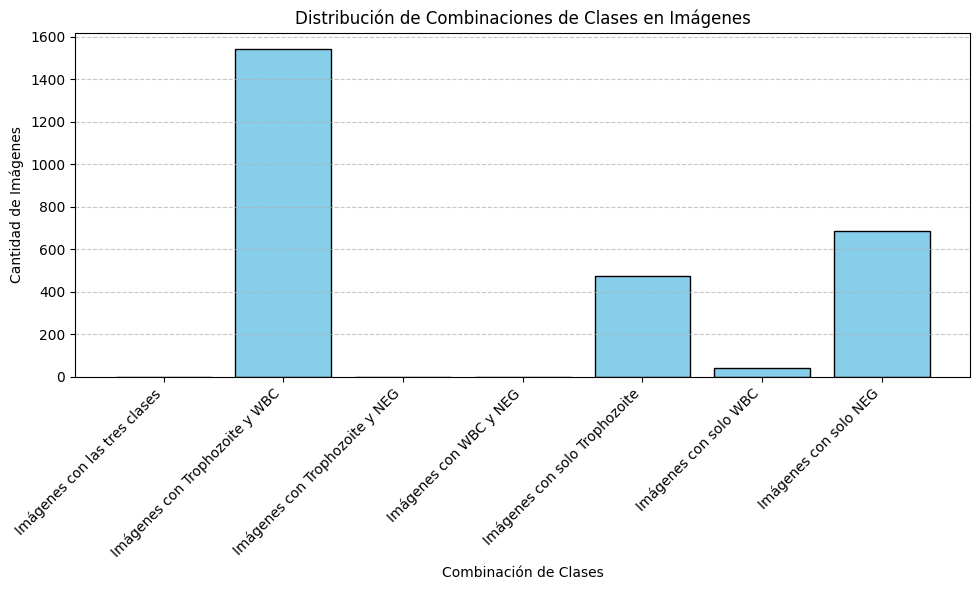

In [17]:
# Crear el DataFrame con los conteos de las clases por cada 'Image_ID'
class_counts = (
    df_train.groupby("Image_ID")["class"]
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

# Renombrar las columnas para mayor claridad
class_counts.columns = ["Image_ID", "NEG", "Trophozoite", "WBC"]

# Reordenar las columnas para mayor claridad
class_counts = class_counts[["Image_ID", "Trophozoite", "WBC", "NEG"]]

# Contar las combinaciones
# Imágenes con las tres clases
three_classes = class_counts[
    (class_counts["Trophozoite"] > 0) &
    (class_counts["WBC"] > 0) &
    (class_counts["NEG"] > 0)
]

# Combinaciones de dos clases
two_classes_troph_wbc = class_counts[
    (class_counts["Trophozoite"] > 0) & (class_counts["WBC"] > 0) & (class_counts["NEG"] == 0)
]

two_classes_troph_neg = class_counts[
    (class_counts["Trophozoite"] > 0) & (class_counts["NEG"] > 0) & (class_counts["WBC"] == 0)
]

two_classes_wbc_neg = class_counts[
    (class_counts["WBC"] > 0) & (class_counts["NEG"] > 0) & (class_counts["Trophozoite"] == 0)
]

# Imágenes con solo una clase
only_troph = class_counts[
    (class_counts["Trophozoite"] > 0) & (class_counts["WBC"] == 0) & (class_counts["NEG"] == 0)
]

only_wbc = class_counts[
    (class_counts["WBC"] > 0) & (class_counts["Trophozoite"] == 0) & (class_counts["NEG"] == 0)
]

only_neg = class_counts[
    (class_counts["NEG"] > 0) & (class_counts["Trophozoite"] == 0) & (class_counts["WBC"] == 0)
]

# Resumen de combinaciones
summary = {
    "Imágenes con las tres clases": len(three_classes),
    "Imágenes con Trophozoite y WBC": len(two_classes_troph_wbc),
    "Imágenes con Trophozoite y NEG": len(two_classes_troph_neg),
    "Imágenes con WBC y NEG": len(two_classes_wbc_neg),
    "Imágenes con solo Trophozoite": len(only_troph),
    "Imágenes con solo WBC": len(only_wbc),
    "Imágenes con solo NEG": len(only_neg),
}

# Convertir el resumen a un DataFrame para graficar
summary_df = pd.DataFrame(list(summary.items()), columns=["Combinación", "Cantidad"])

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(summary_df["Combinación"], summary_df["Cantidad"], color="skyblue", edgecolor="black")
plt.title("Distribución de Combinaciones de Clases en Imágenes")
plt.xlabel("Combinación de Clases")
plt.ylabel("Cantidad de Imágenes")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()



# Creando el conjunto de datos para el entrenamiento

Con base en:

https://www.kaggle.com/code/swarnabh31/computervision-end-to-end-transferlearning

y reduciendo el deafio a un problema de clasificacion

Revisar https://en.wikipedia.org/wiki/Trophozoite

In [18]:
df_train_ = df_train.copy()

In [19]:
id_malaria = df_train_[df_train_['class']=='Trophozoite'].Image_ID.unique()

In [20]:
df_train_['Malaria'] = np.nan
df_train_.loc[df_train_.Image_ID.isin(id_malaria),'Malaria'] = 'Malaria_SI'
df_train_.loc[~df_train_.Image_ID.isin(id_malaria),'Malaria'] = 'Malaria_NO'
df_train_.head()

<ipython-input-20-aed07519f5fc>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Malaria_SI' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_train_.loc[df_train_.Image_ID.isin(id_malaria),'Malaria'] = 'Malaria_SI'


Image_ID        class  confidence  ymin  xmin  ymax  xmax  \
0  id_u3q6jdck4j.jpg  Trophozoite         1.0   712  1241   737  1270   
1  id_a6cl90trri.jpg  Trophozoite         1.0   558  1566   600  1604   
2  id_qvc2le9sm8.jpg  Trophozoite         1.0  1317  2788  1448  2914   
3  id_w8xnbd5rvm.jpg  Trophozoite         1.0   925  1744  1041  1823   
4  id_6dop09rk02.jpg          NEG         1.0     0     0     0     0   

      Malaria  
0  Malaria_SI  
1  Malaria_SI  
2  Malaria_SI  
3  Malaria_SI  
4  Malaria_NO

In [21]:
df_train_final = df_train_.dropna()
df_train_final = df_train_[['Image_ID','Malaria']].drop_duplicates()
df_train_final.head()

Image_ID     Malaria
0  id_u3q6jdck4j.jpg  Malaria_SI
1  id_a6cl90trri.jpg  Malaria_SI
2  id_qvc2le9sm8.jpg  Malaria_SI
3  id_w8xnbd5rvm.jpg  Malaria_SI
4  id_6dop09rk02.jpg  Malaria_NO

In [22]:
print(df_train_final.shape,df_train_final.Image_ID.nunique())


(2747, 2) 2747


In [23]:
df_train_final.groupby('Malaria').count()

Image_ID
Malaria             
Malaria_NO       729
Malaria_SI      2018

<Axes: xlabel='Malaria', ylabel='count'>

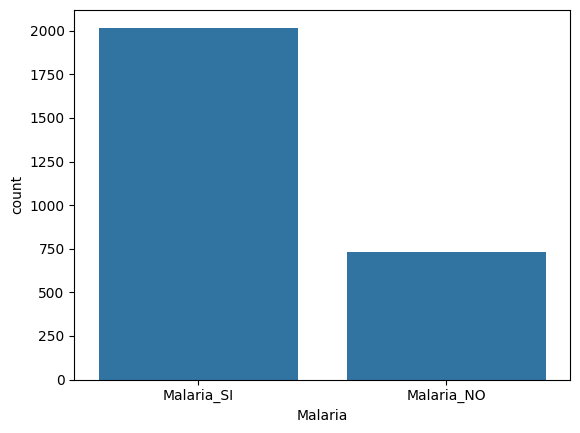

In [24]:
sns.countplot(df_train_final, x="Malaria")

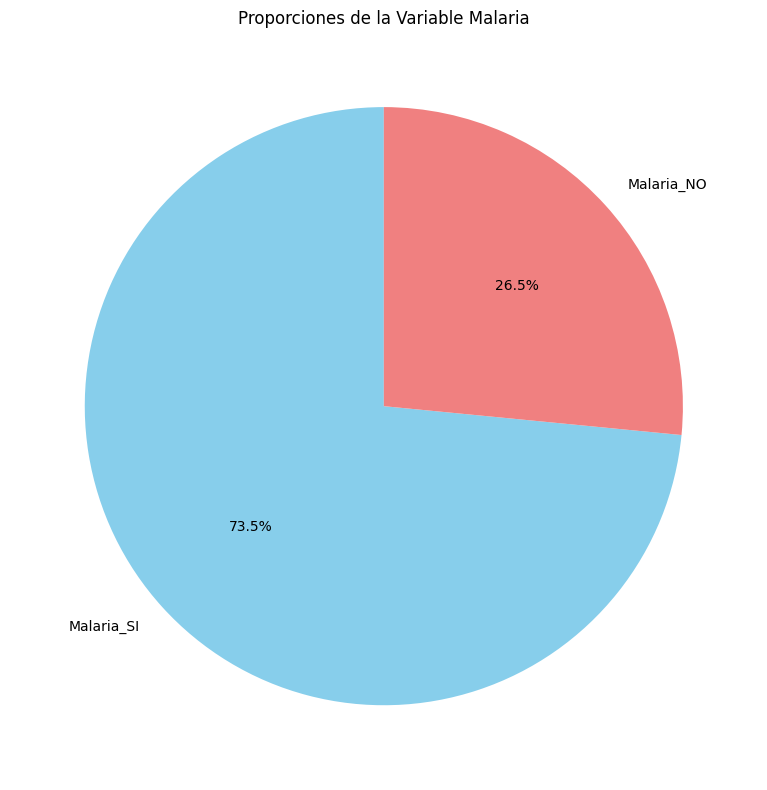

In [25]:
# Calcular las proporciones de la variable 'Malaria'
malaria_proportions = df_train_final['Malaria'].value_counts(normalize=True)

# Crear el gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(
    malaria_proportions,
    labels=malaria_proportions.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'lightcoral']
)
plt.title('Proporciones de la Variable Malaria')
plt.tight_layout()
plt.show()


In [26]:
df_train_final[df_train_final['Malaria']=='Malaria_SI'].Image_ID.nunique()

2018

In [27]:
df_train_final[df_train_final['Malaria']=='Malaria_NO'].Image_ID.nunique()

729

In [28]:
2018+729

2747

In [29]:
# Create image paths for training data
df_train_final['image_path'] = df_train_final['Image_ID'].apply(lambda x: os.path.join(image_dir, x))
df_train_final.head()

Image_ID     Malaria  \
0  id_u3q6jdck4j.jpg  Malaria_SI   
1  id_a6cl90trri.jpg  Malaria_SI   
2  id_qvc2le9sm8.jpg  Malaria_SI   
3  id_w8xnbd5rvm.jpg  Malaria_SI   
4  id_6dop09rk02.jpg  Malaria_NO   

                                          image_path  
0  /root/.cache/kagglehub/datasets/rajsahu2004/la...  
1  /root/.cache/kagglehub/datasets/rajsahu2004/la...  
2  /root/.cache/kagglehub/datasets/rajsahu2004/la...  
3  /root/.cache/kagglehub/datasets/rajsahu2004/la...  
4  /root/.cache/kagglehub/datasets/rajsahu2004/la...

# Entrenar modelo

In [30]:
# Split training data into train and validation sets
train_data, val_data = train_test_split(
    df_train_final,
    test_size=0.3,
    random_state=42,
    stratify=df_train_final['Malaria']
)

In [44]:
# Only rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# Only rescaling for validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
batch_size = 8

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='Malaria',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle= True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='Malaria',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False
)

# Calculate class weights to handle imbalance
y_train = train_generator.classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


# Prepare test data
df_test['image_path'] = df_test['Image_ID'].apply(lambda x: os.path.join(image_dir, x))
test_generator = val_test_datagen.flow_from_dataframe(
    df_test,
    x_col='image_path',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 1922 validated image filenames belonging to 2 classes.
Found 825 validated image filenames belonging to 2 classes.
Class Weights: {0: 1.884313725490196, 1: 0.6805949008498584}
Found 1178 validated image filenames.


In [45]:
# Print some information about the data
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Number of training samples: {len(train_generator)}")
print(f"Number of validation samples: {len(val_generator)}")
print(f"Number of test samples: {len(test_generator)}")

# Check class balance
print("\nClass distribution in training data:")
print(train_data['Malaria'].value_counts(normalize=True))
print("\nClass distribution in validation data:")
print(val_data['Malaria'].value_counts(normalize=True))

Number of classes: 2
Number of training samples: 241
Number of validation samples: 104
Number of test samples: 148

Class distribution in training data:
Malaria
Malaria_SI    0.734651
Malaria_NO    0.265349
Name: proportion, dtype: float64

Class distribution in validation data:
Malaria
Malaria_SI    0.734545
Malaria_NO    0.265455
Name: proportion, dtype: float64


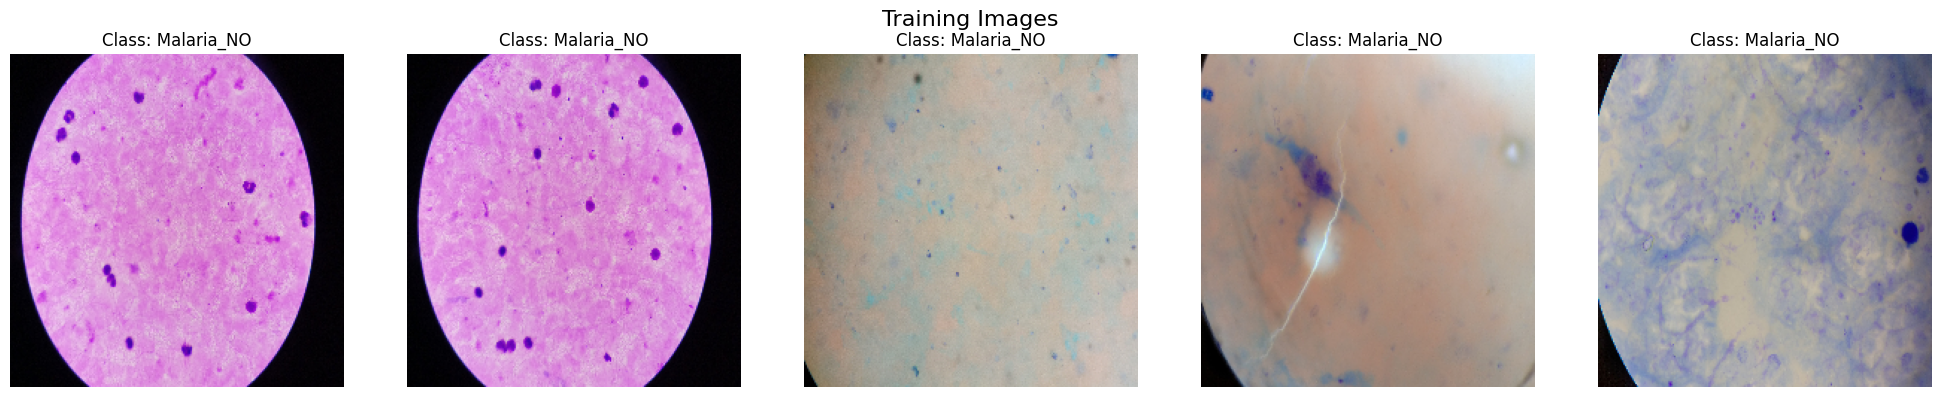

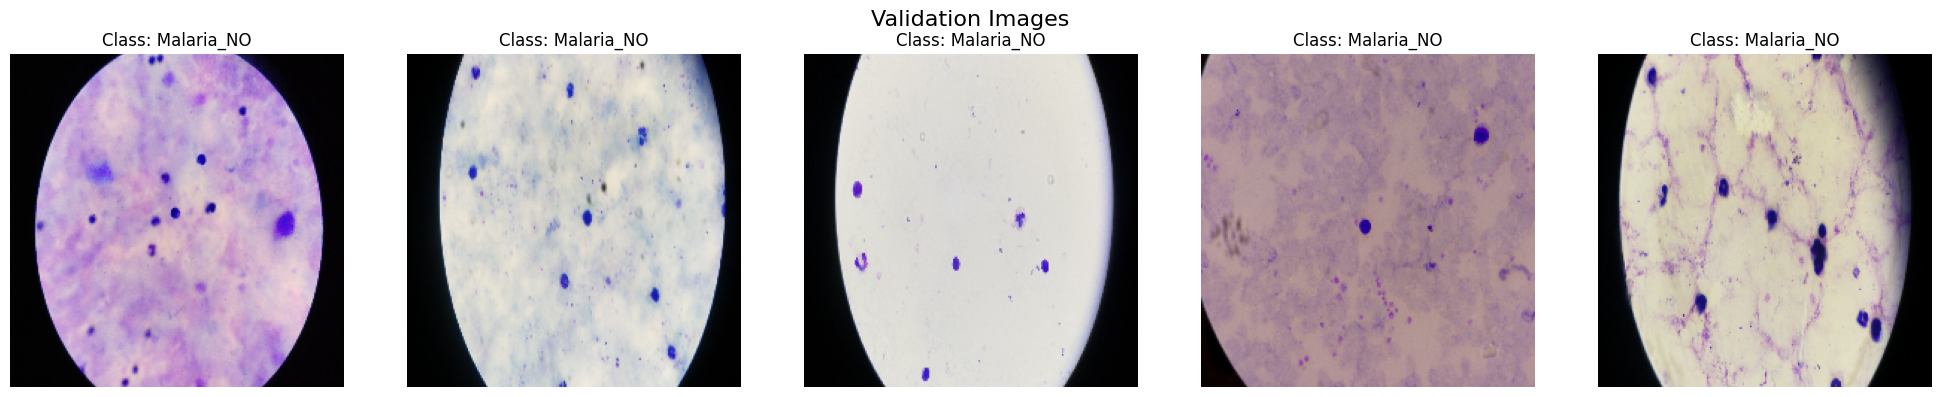

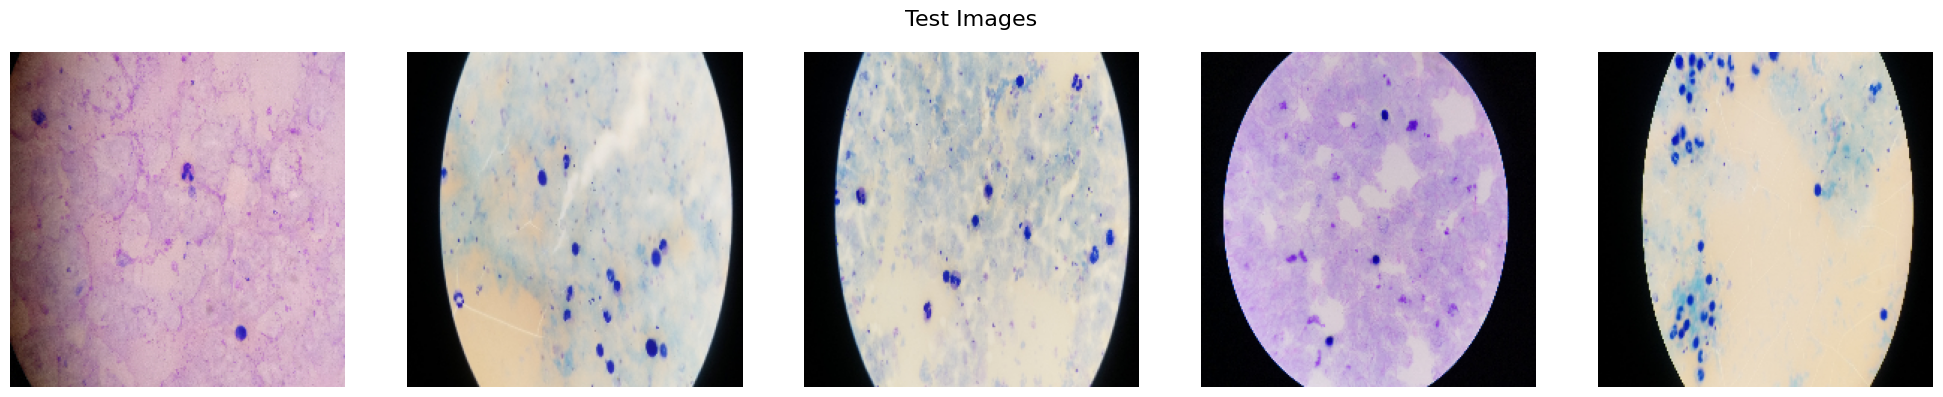

In [46]:
def plot_images(generator, title, n=5):
    plt.figure(figsize=(20, 4))
    plt.suptitle(title, fontsize=16)

    # Check if the generator has class information
    has_classes = hasattr(generator, 'class_indices')

    if has_classes:
        # Get the class indices
        class_indices = generator.class_indices
        # Invert the dictionary to map indices to class names
        index_to_class = {v: k for k, v in class_indices.items()}

    for i in range(n):
        # Get a batch of images
        batch = next(generator)

        # For train and validation, batch is a tuple (images, labels)
        # For test, batch is just images
        if isinstance(batch, tuple):
            images, labels = batch
        else:
            images = batch

        # Select a random image from the batch
        idx = np.random.randint(0, images.shape[0])
        img = images[idx]

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')

        if has_classes and isinstance(batch, tuple):
            label_idx = np.argmax(labels[idx])
            class_name = index_to_class[label_idx]
            plt.title(f"Class: {class_name}")

    plt.tight_layout()
    plt.show()

# Visualize training images
plot_images(train_generator, "Training Images")

# Visualize validation images
plot_images(val_generator, "Validation Images")

# Visualize test images
plot_images(test_generator, "Test Images")


In [47]:
steps_per_epoch = len(train_data) // batch_size
steps_per_epoch

240

In [48]:
# Create an input layer
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))

model = tf.keras.models.Sequential([
    input_layer,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),


    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),


    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      22,151,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,180,065 (84.61 MB)

 Trainable params: 22,180,065 (84.61 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [50]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [51]:
# Train the model
history_frozen = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    class_weight=class_weights,
    validation_data=val_generator,
    validation_steps=None,
    callbacks=[lr_scheduler,early_stopping],
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


240/240 ━━━━━━━━━━━━━━━━━━━━ 167s 668ms/step - accuracy: 0.9130 - loss: 0.4026 - val_accuracy: 0.9527 - val_loss: 0.1510 - learning_rate: 0.0010
Epoch 2/20
  1/240 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 1.0000 - loss: 0.0258

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


240/240 ━━━━━━━━━━━━━━━━━━━━ 51s 214ms/step - accuracy: 1.0000 - loss: 0.0258 - val_accuracy: 0.9527 - val_loss: 0.1548 - learning_rate: 0.0010
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 161s 663ms/step - accuracy: 0.9725 - loss: 0.1221 - val_accuracy: 0.9758 - val_loss: 0.0488 - learning_rate: 0.0010
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 191ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.9830 - val_loss: 0.0459 - learning_rate: 0.0010
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 210s 634ms/step - accuracy: 0.9737 - loss: 0.1016 - val_accuracy: 0.9903 - val_loss: 0.0325 - learning_rate: 0.0010
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 82s 343ms/step - accuracy: 1.0000 - loss: 0.0404 - val_accuracy: 0.9903 - val_loss: 0.0325 - learning_rate: 0.0010
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 170s 690ms/step - accuracy: 0.9850 - loss: 0.0435 - val_accuracy: 0.9418 - val_loss: 0.1007 - learning_rate: 0.0010
Epoch 8/20
  1/240 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 1.0000 - loss

# Resultados

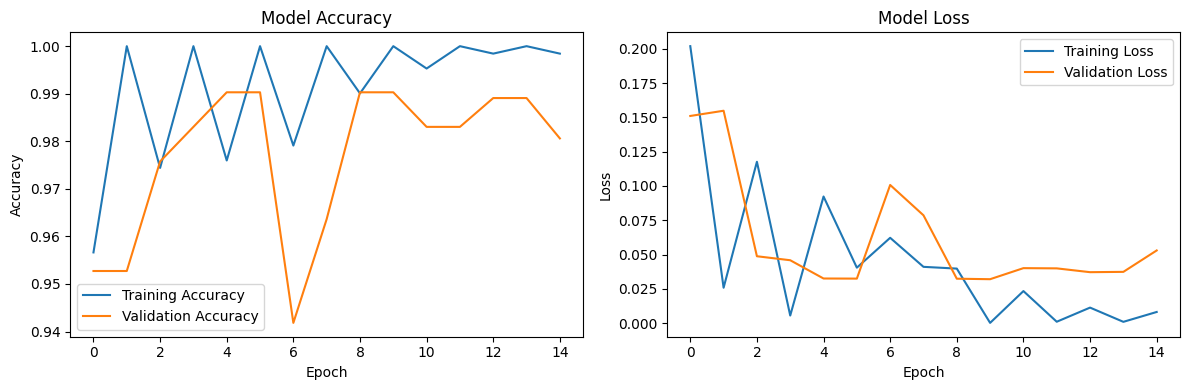

In [52]:
# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_frozen.history['accuracy'], label='Training Accuracy')
plt.plot(history_frozen.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_frozen.history['loss'], label='Training Loss')
plt.plot(history_frozen.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Save the model
model.save("malaria_detection_model.h5")

104/104 ━━━━━━━━━━━━━━━━━━━━ 50s 477ms/step - accuracy: 0.9931 - loss: 0.0248


Validation Loss: 0.032034389674663544
Validation Accuracy: 0.9903030395507812


# Pruebas sobre el modelo

104/104 ━━━━━━━━━━━━━━━━━━━━ 48s 452ms/step
Precision: 0.988562091503268
Recall: 0.9983498349834984
F1-Score: 0.993431855500821
104/104 ━━━━━━━━━━━━━━━━━━━━ 48s 461ms/step


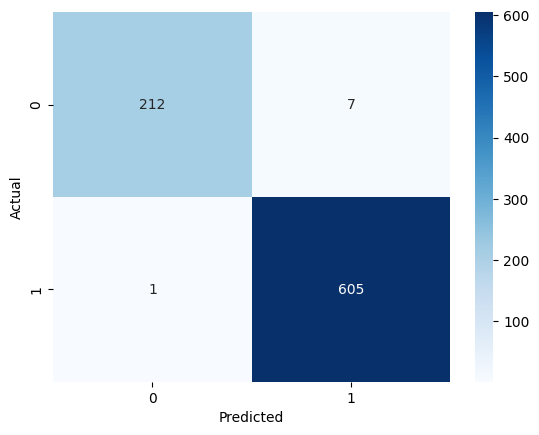

In [57]:
def evaluate_model(model, generator):
    y_true = generator.classes  # Ground truth labels
    y_pred_probs = model.predict(generator)  # Model predictions
    y_pred = (y_pred_probs > 0.5).astype(int)  # Binary predictions

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

# Evaluate model
evaluate_model(model, val_generator)

# Visualize Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = val_generator.classes
y_pred = (model.predict(val_generator) > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()